# Import Packages

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import gower
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, HDBSCAN, Birch, MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np
from itertools import combinations, chain
from tqdm import tqdm
import matplotlib.pyplot as plt
import kmedoids
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

# Load Data

In [6]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()

df = df[df["first_data_year"] >= 2021]

In [7]:
cols_to_drop_init = ["welcome_discount", "policy_nr_hashed", "control_group", "churn", "last_data_year", "first_datapoint_year", "last_datapoint_year", "first_data_year", 'last_type', 'lpa', 'count', 'cluster']
cols_to_keep = [col for col in df.columns if col not in cols_to_drop_init]

df_filt = df[cols_to_keep]

dist_matrix = gower.gower_matrix(df_filt)
# dist_matrix = pd.read_csv("../data/gower_matrix.csv").to_numpy()

# Apply Clustering

In [8]:
def kmeans_cluster(dist_matrix, n):
    cluster = MiniBatchKMeans(n_clusters=n, random_state=0, n_init='auto').fit(dist_matrix)

    sh_score = silhouette_score(dist_matrix, cluster.labels_)
    db_score = davies_bouldin_score(dist_matrix, cluster.labels_)
    ch_score = calinski_harabasz_score(dist_matrix, cluster.labels_)

    return sh_score, db_score, ch_score, cluster

def kmedoids_cluster(dist_matrix, n):
    cluster = kmedoids.KMedoids(n, method='fasterpam', init='build', random_state=0).fit(dist_matrix)

    sh_score = silhouette_score(dist_matrix, cluster.labels_)
    db_score = davies_bouldin_score(dist_matrix, cluster.labels_)
    ch_score = calinski_harabasz_score(dist_matrix, cluster.labels_)

    return sh_score, db_score, ch_score, cluster

def spectral_cluster(dist_matrix, n):
    cluster_labels = SpectralClustering(n_clusters=n, affinity='rbf', n_init=100, assign_labels='discretize').fit_predict(dist_matrix)

    sh_score = silhouette_score(dist_matrix, cluster_labels, metric="precomputed")
    db_score = davies_bouldin_score(dist_matrix, cluster_labels)
    ch_score = calinski_harabasz_score(dist_matrix, cluster_labels)

    return sh_score, db_score, ch_score, cluster_labels

In [9]:
# sh_score, db_score, ch_score, cluster = kmeans_cluster(dist_matrix, 5)
sh_score, db_score, ch_score, cluster = kmedoids_cluster(dist_matrix, 5)
# sh_score, db_score, ch_score, cluster = spectral_cluster(dist_matrix, 5)

print(f"Silhouette Score: {np.round(sh_score, 3)}")
print(f"Davies Bouldin: {np.round(db_score, 3)}")
print(f"Calinski Harabasz Score: {np.round(ch_score, 3)}")

Silhouette Score: 0.12700000405311584
Davies Bouldin: 2.187
Calinski Harabasz Score: 5420.523


In [12]:
df.loc[:,"cluster"] = cluster.labels_

policy_clusters = df[["policy_nr_hashed", "cluster"]]

,policy_nr_hashed
cluster,
0,6124
1,6462
2,7098
3,6352
4,3594


In [35]:
sh_list = []
db_list = []
ch_list = []
n_list = []

for n in tqdm(np.arange(2, 21, 1)):
    sh_score, db_score, ch_score, cluster = kmedoids_cluster(dist_matrix, int(n))

    sh_list.append(sh_score)
    db_list.append(db_score)
    ch_list.append(ch_score)
    n_list.append(n)

100%|██████████| 19/19 [06:00<00:00, 18.99s/it]


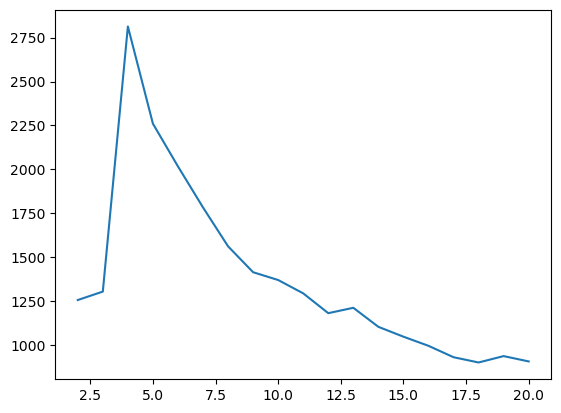

In [36]:
plt.plot(n_list, ch_list)
plt.show()

In [37]:
sh_score, db_score, ch_score, cluster = kmedoids_cluster(dist_matrix, 5)

mean_agg = {col: pd.NamedAgg(column=col, aggfunc='mean') for col in df_filt.columns if df_filt[col].dtype != 'object'}

df_filt.loc[:,"cluster"] = cluster.labels_

df_clust = (
    df_filt
    .groupby("cluster")
    .agg(
        count=pd.NamedAgg(column="cluster", aggfunc="count"),
        **mean_agg
    )
).drop(["last_postcode", "count", "perc_western_ppl", "perc_nld_ppl", "perc_others_ppl", "last_allrisk royaal", "last_allrisk compleet", "last_vs_first_split", "last_wa-extra", "cluster", "policyholder_change", "n_last_vs_peak", "fake_alarm", "last_allrisk basis", "last_split", "max_nr_coverages", "nr_years", "cum_change_premium_abs", "cum_change_premium_perc", "pc4", "last_premium"], axis=1)

np_clust_expl = StandardScaler().fit_transform(df_clust)

def top_5_columns_with_values(row):
    # Get the top 5 absolute values and their corresponding column names
    top_5 = row.abs().nlargest(10)
    # Create a dictionary mapping column names to their raw values in the row
    top_5_dict = {col: np.round(row[col], 2) for col in top_5.index if np.abs(row[col]) >= 0.8}
    return top_5_dict

df_clust_expl = pd.DataFrame(np_clust_expl, columns=df_clust.columns, index=df_clust.index)

top_5_per_row = df_clust_expl.apply(top_5_columns_with_values, axis=1).tolist()

for i in range(len(top_5_per_row)):
    print(i, ":", top_5_per_row[i])
    print("")

0 : {'last_car_value': 1.65, 'last_weight': 1.65, 'last_customer_age': 1.43, 'accident_years': 1.41, 'last_accident_free_years': 1.24, 'last_age_car': -1.17, 'nr_cars': 0.97, 'house_worth': 0.93}

1 : {'65y_plus': -1.86, '4_tot_65y': -1.62, 'females': -1.49, 'nr_ppl': -1.48, 'males': -1.48, 'nr_homes': -1.48, 'nr_households': -1.41, 'tot_15y': -1.39, '15_tot_25y': -1.37, '25_tot_45y': -1.24}

2 : {'last_age_car': -0.87}

3 : {'last_nr_coverages': -1.97, 'livability': -1.94, 'density': 1.91, 'perc_low_income': 1.88, 'median_income_household': -1.87, 'ppl_social_help': 1.86, 'household_size': -1.82, '25_tot_45y': 1.82, '15_tot_25y': 1.72, 'perc_high_income': -1.71}

4 : {'house_worth': -1.91, 'last_age_car': 1.48, 'last_car_value': -1.39, 'last_weight': -1.38, 'first_premium': -1.37, 'first_split': -1.12, 'accident_years': -1.05, 'last_accident_free_years': -0.9, 'last_customer_age': -0.87}



# Classifier

In [40]:
display(df_filt)

,first_premium,last_premium,first_split,last_split,last_customer_age,last_accident_free_years,last_car_value,last_age_car,last_brand,last_weight,...,household_size,nr_homes,house_worth,median_income_household,perc_low_income,perc_high_income,ppl_social_help,density,livability,cluster
1,3661.056,3513.216,0.805800,0.791507,56,10,143360.0,6,citroen,815,...,2.1,1070,203000,30400,40.5,16.2,280,281,5.0,1
2,7766.752,7766.752,0.908517,0.908517,59,39,720619.2,4,mercedes,1635,...,2.1,1070,203000,30400,40.5,16.2,280,281,5.0,0
15,3572.800,3415.552,0.804357,0.777643,52,1,238347.2,16,opel,1270,...,2.1,1070,203000,30400,40.5,16.2,280,281,5.0,1
16,9639.168,9639.168,0.926241,0.926241,44,16,1074236.8,3,landrover,1874,...,2.1,1070,203000,30400,40.5,16.2,280,281,5.0,0
19,4724.160,4724.160,0.849502,0.849502,44,1,699507.2,15,saab,1580,...,2.1,1070,203000,30400,40.5,16.2,280,281,5.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28971,10389.120,10389.120,0.929495,0.929495,52,26,582120.0,4,volkswagen,1543,...,2.0,3620,359000,38300,35.0,28.9,390,1782,9.0,0
28974,3162.432,3162.432,0.838079,0.838079,37,9,168672.0,9,peugeot,935,...,2.0,3620,359000,38300,35.0,28.9,390,1782,9.0,0
28975,9569.280,9569.280,0.923455,0.923455,44,0,449008.0,6,mini,1320,...,2.0,3620,359000,38300,35.0,28.9,390,1782,9.0,4
28976,7625.856,7625.856,0.906768,0.906768,56,28,681307.2,1,bmw,1405,...,2.0,3620,359000,38300,35.0,28.9,390,1782,9.0,0


In [49]:
X = df_filt[[col for col in df_filt.columns if col != "cluster"]]
y = df_filt['cluster']

for col in X.columns:
     if X[col].dtype == "object":
        X[col] = X[col].astype("category")

# Run model selection
space = {
    'max_depth': hp.uniformint('max_depth', 50, 100),
    'n_estimators': hp.uniformint('n_estimators', 50, 200),
    'num_leaves': hp.uniformint('num_leaves', 2, 200),
    'min_child_samples': hp.uniformint('min_child_samples', 7, 100),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.25, 1),
    'subsample': hp.uniform('subsample', 0.25, 1),
    'subsample_freq': hp.uniformint('subsample_freq', 1, 100),
    'reg_alpha': hp.uniform('reg_alpha', 0, 0.2),
    'reg_lambda': hp.uniform('reg_lambda', 0, 0.2),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.5),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'min_data_in_leaf': hp.uniformint('min_data_in_leaf', 1, 21),
}

def objective(params):
    clf = lgb.LGBMClassifier(
        objective='multiclass',
        force_row_wise=True,
        verbosity=-1,
        random_state=0,
        # is_unbalance=True,
        **params
    )
    score = cross_val_score(clf, X, y, cv=5, scoring="f1_macro").mean()
    return {'loss': -score, 'status': STATUS_OK}

n_iter = 10
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=n_iter, trials=trials, rstate=np.random.default_rng(seed=0))

print("Best Score is: ", -trials.best_trial['result']['loss'])
print("Best Parameters: ", best)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/var/folders/s0/7_fb0swx3w172221bbtj_36m0000gp/T/ipykernel_92585/3255655015.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
/var/folders/s0/7_fb0swx3w172221bbtj_36m0000gp/T/ipykernel_92585/3255655015.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype("category")
/var/folders/s0/7_fb0swx3w172221bbtj_36m0000gp/T/ipykernel_92585/3255655015.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

100%|██████████| 10/10 [01:41<00:00, 10.12s/trial, best loss: -0.9256428190286694]
Best Score is:  0.9256428190286694
Best Parameters:  {'colsample_bytree': 0.27487280326701813, 'learning_rate': 0.07246171615248667, 'max_depth': 82.0, 'min_child_samples': 41.0, 'min_data_in_leaf': 11.0, 'min_split_gain': 0.30450698014734146, 'n_estimators': 174.0, 'num_leaves': 60.0, 'reg_alpha': 0.1962854337188671, 'reg_lambda': 0.014928393685353326, 'subsample': 0.9927311699186233, 'subsample_freq': 73.0}


In [58]:
# Save best model
best_params = {
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'num_leaves': int(best['num_leaves']),
    'min_child_samples': int(best['min_child_samples']),
    'colsample_bytree': best['colsample_bytree'],
    'subsample': best['subsample'],
    'subsample_freq': int(best['subsample_freq']),
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    'min_split_gain': best['min_split_gain'],
    'learning_rate': best['learning_rate'],
    'min_data_in_leaf': int(best['min_data_in_leaf']),
}

lgbm_best = lgb.LGBMClassifier(
    objective='multiclass',
    force_row_wise=True,
    verbosity=-1,
    random_state=0,
    # is_unbalance=True,
    **best_params
)

print(f"Accuracy: {np.mean(cross_val_score(lgbm_best, X, y, cv=5, scoring='accuracy'))}")
print(f"F1 Macro: {np.mean(cross_val_score(lgbm_best, X, y, cv=5, scoring='f1_macro'))}")
print(f"F1 Micro: {np.mean(cross_val_score(lgbm_best, X, y, cv=5, scoring='f1_micro'))}")

Accuracy: 0.9321999999999999
F1 Macro: 0.9256428190286694
F1 Micro: 0.9321999999999999


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lgbm_best = lgbm_best.fit(X_train, y_train)
y_pred = lgbm_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[399  13  15   5  11]
 [  4 588  10   0  10]
 [  5  13 691   9   6]
 [  0   0   5 311   3]
 [  3  24   7   7 861]]
